## import the libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import uproot3
import dask.dataframe as dd
import time
from dask import delayed
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import seaborn as sns
import os

pd.pandas.set_option('display.max_columns',None)

## Check if jupyter notebook or script

In [3]:
def in_ipynb():
    try:
        cfg = get_ipython().config
        print(cfg)
        if 'jupyter' in cfg['IPKernelApp']['connection_file']:
            return True
        else:
            return False
    except NameError:
        return False

In [4]:
if in_ipynb():
    print("In IPython")
    TrainConfig="Configs/MultiClassification_XGBoost_barrel"
    exec("import "+TrainConfig.replace("/", ".")+" as Conf")
else:
    TrainConfig=sys.argv[1]
    print("Importing settings from "+ TrainConfig.replace("/", "."))
    #exec("from "+TrainConfig+" import *")
    importConfig=TrainConfig.replace("/", ".")
    exec("import "+importConfig+" as Conf")

{'IPKernelApp': {'connection_file': '/scratch/rchudasa/.local/share/jupyter/runtime/kernel-2da21d8d-a0dc-4051-b469-780d3b097a0b.json'}, 'InteractiveShellApp': {'extensions': <LazyConfigValue value=['sparkmonitor.kernelextension', 'swankernelenv']>}}
In IPython


2022-11-10 12:06:45.030527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-88592/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-35f7a/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

In [5]:
import os
os.system("")
os.system("mkdir -p " + Conf.OutputDirName)

0

### Function to return pandas dataframe from root file 

In [6]:
def get_pandasDataFrame(process,cat,path,fileName,treeName,branches,selection,fraction):
    print(selection)
    eventsPhoton  = uproot3.open(path+fileName)[treeName]
    #pd_dataframe  = eventsPhoton.pandas.df(branches=branches)
    pd_dataframe  = eventsPhoton.pandas.df(branches=branches).query(selection)
    pd_dataframe['Class'] = process
    pd_dataframe['Category'] = cat
    pd_dataframe = pd_dataframe.sample(frac=fraction)
    
    print(pd_dataframe.shape)
    return pd_dataframe

### Append pandas dataframe to dask framework using delayed to reduce the computing time

In [7]:
dfs= []
start = time.time()
for process in Conf.processes:
    path = Conf.baseInputPath
    pr = process['Class']
    cat = process['category']
    fileName  = process['fileName']
    treeName  = process['treeName']
    selection = process['selection']
    fraction  = process['fraction']
    print(path,fileName,treeName,fraction)
    dfs.append(delayed(get_pandasDataFrame(pr,cat,path,fileName,treeName,branches=Conf.branches,selection=selection,fraction=fraction)))
end  = time.time()
print("Execution time is", end-start)


/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_signal_bsMMG_barrel.root genMatchedBMMGSCTree 0.3
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(54040, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_qcd20To30EmEnriched_barrel.root mergedPi0_SCTree 1
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(64661, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ mc_bkg_flat_pi0_barrel.root mergedPi0_SCTree 1
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(49507, 26)
/eos/user/r/rchudasa/SWAN_projects/photonID-pp-Run2/makeInputTrees/workarea/ data_2018D_barrel.root dataAllSCTree 0.1
(scEt>4) & (scEt<15) & abs(scEta)<1.4442 & (scFoundGsfMatch_ < 1)
(54344, 26)
Execution time is 2.8091208934783936


In [8]:
daskframe = dd.from_delayed(dfs)
final_df = daskframe.compute()
final_df.reset_index(inplace=True, drop=True)

In [9]:
final_df.head()

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Class,Category
0,7.612641,4.364994,1.154637,2.458142,0.014297,1.000000e+09,0.0,0.886470,0.007114,0.000002,0.656240,0.476167,1.000000,0.148881,3.372590,3.372590,4.238997,5.962224,6.208840,2.616682,2.616682,5.633833,8.048589,12.063632,Signal,0
1,10.268811,5.444023,-1.248644,-0.664056,0.036444,1.000000e+09,0.0,0.703200,0.015309,-0.000089,0.571211,0.445584,0.897011,0.265132,3.351559,3.611530,3.611530,4.889325,7.142009,0.000000,1.596442,2.422061,8.291380,10.248260,Signal,0
2,7.321876,5.001083,0.929557,-0.933871,0.007651,2.245841e+00,0.0,0.688784,0.009387,0.000026,0.723485,0.736497,1.000000,0.108718,4.350082,4.660449,5.993894,8.206876,9.328171,1.887269,2.423234,6.402352,11.477100,16.647730,Signal,0
3,8.477271,7.590605,0.478759,1.329975,0.008747,1.000000e+09,0.0,0.678506,0.008136,0.000028,0.513293,0.051796,1.000000,0.256654,1.674712,1.674712,2.029678,3.529204,4.279602,6.355587,10.682564,14.447303,16.944557,23.501209,Signal,0
4,5.148602,4.997699,0.245128,-0.516368,0.004604,1.000000e+09,0.0,0.929679,0.007760,0.000008,0.872623,0.854030,1.000000,0.068986,4.839082,4.839082,4.839082,4.839082,5.123136,3.694202,5.177757,8.206908,10.729901,13.100916,Signal,0


In [10]:
final_df.tail()

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Class,Category
222547,9.333681,6.465915,-0.910093,-1.137695,0.007335,2.770633e+00,0.0,0.744882,0.009098,0.000000,0.720550,0.612170,1.000000,0.279450,6.100857,7.119668,9.888049,11.060945,11.263238,21.945841,28.801649,29.225948,29.710730,30.564978,Data,3
222548,7.915595,7.481329,0.339098,2.203495,0.008375,2.607118e+00,0.0,0.998393,0.011032,0.000003,0.564805,0.599431,0.965407,0.174358,5.878809,9.360914,11.767120,11.767120,14.247921,27.538717,39.355255,42.648666,46.289780,60.435966,Data,3
222549,4.442907,4.018610,-0.455578,1.413803,0.000973,1.000000e+09,0.0,0.929301,0.000000,0.000000,0.929648,0.924324,1.000000,0.070352,3.500710,3.500710,3.779369,3.779369,5.070140,1.127063,2.048072,4.197660,6.174308,10.791481,Data,3
222550,8.873695,5.476982,-1.062960,2.430576,0.023189,1.000000e+09,0.0,0.613766,0.000000,0.000000,0.506421,0.025358,1.000000,0.493579,3.433844,6.029370,6.790549,7.202757,7.649904,8.400494,10.365823,13.361828,18.128450,26.615656,Data,3
222551,7.892036,4.478902,-1.167156,1.627406,0.041246,4.144467e+00,0.0,0.759050,0.008137,-0.000012,0.804639,0.757206,1.000000,0.099349,5.448043,6.720350,8.469500,10.709260,12.692904,10.818454,14.530836,21.189116,26.018072,27.847092,Data,3


In [11]:
final_df.shape

(222552, 26)

## Prepare the dataframe for reweighting and finding weights  

In [12]:
final_df['Class'].unique()

array(['Signal', 'QCD', 'Pi0', 'Data'], dtype=object)

In [13]:
final_df["NewWt"]=1
final_df["xsecwt"]=1


In [14]:
Classes=Conf.Classes

## Divide the dataframe for training and testing
adapted from LPC Egamma ID tutorial

In [15]:
index = final_df.index
from sklearn.model_selection import train_test_split
TrainIndices=[]
TestIndices=[]
for myclass in Classes:
    condition = final_df["Class"] == myclass
    Indices = index[condition].values.tolist()
    myclassTrainIndices, myclassTestIndices = train_test_split(Indices, test_size=0.25, random_state=42, shuffle=True)
    TrainIndices=TrainIndices + myclassTrainIndices
    TestIndices=TestIndices + myclassTestIndices

final_df.loc[TrainIndices,'Dataset'] = "Train"
final_df.loc[TestIndices,'Dataset'] = "Test"

final_df.loc[TrainIndices,'TrainDataset'] = 1
final_df.loc[TestIndices,'TrainDataset'] = 0

In [16]:
#final_df[(final_df['Dataset']=='Train') & (final_df['Class']=='bkg')].shape

In [17]:
#final_df[(final_df['Dataset']=='Train') & (final_df['Class']=='signal')].shape

Text(0.5, 1.0, 'Number of samples')

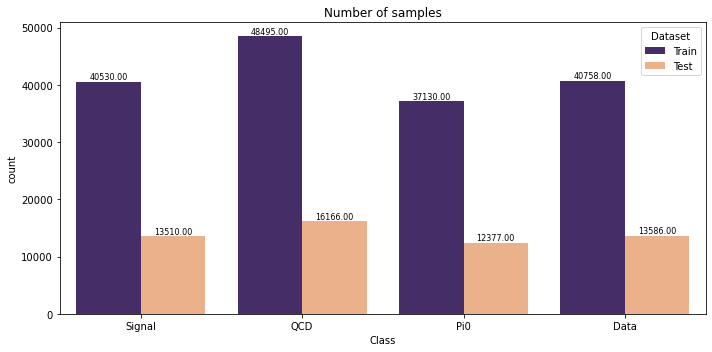

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
kplot=sns.countplot(x="Class", data=final_df, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B","black"])

for p in kplot.patches:
    kplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',size=8)
axes.set_title("Number of samples")

In [19]:
ClassColors = Conf.ClassColors

In [20]:
def MyBins(lower,upper,step): return np.arange(lower,upper,step).tolist() 
def prGreen(prt): print("\033[92m {}\033[00m" .format(prt))


def MakeFeaturePlots(df_final,features,feature_bins,Set="Train",OutputDirName='Figures',cat='Category',label=[""],weight="NewWt",log=False,locate=[""]):
    fig, axes = plt.subplots(1, len(features), figsize=(len(features)*5, 5))
    #fig, axes = plt.subplots(1, 1, figsize=(len(features)*5, 5))

    prGreen("Making "+Set+" dataset spectator plots")
    for m in range(len(features)):
        for i,group_df in df_final[df_final['Dataset'] == Set].groupby(cat):
            print(m, i, cat)
            group_df[features[m]].hist(histtype='step',color=ClassColors[i], bins=feature_bins[m], alpha=1,label=label[i], ax=axes[m], density=False, ls='-', weights =group_df[weight]/group_df[weight].sum(),linewidth=2)
        axes[m].legend(loc=locate[m])
        axes[m].set_xlabel(features[m])
        if log:
            axes[m].set_yscale("log")
            axes[m].set_ylim([0.0001,1.2])
        axes[m].set_title(features[m]+" ("+Set+" Dataset)")
        plt.savefig(OutputDirName+'/'+features[m]+Set+".png".format(m))




 Making Train dataset spectator plots
0 0 Category
0 1 Category
0 2 Category
0 3 Category
1 0 Category
1 1 Category
1 2 Category
1 3 Category


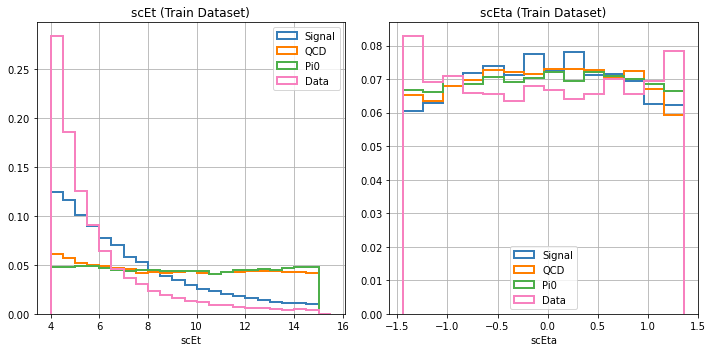

In [21]:
Variables=['scEt','scEta']
VarBins=[MyBins(4,16,0.5), MyBins(-1.44,1.44,0.2)]
loca=['upper right','lower center']
MakeFeaturePlots(final_df,Variables,VarBins,Set="Train",OutputDirName=Conf.OutputDirName,label=Classes,log=False,locate=loca)

## Reweighting 

In [22]:
import Tools.ptetaRwt as ptetaRwt

In [23]:
final_df.loc[TrainIndices,"NewWt"]=ptetaRwt.df_pteta_rwt(final_df.loc[TrainIndices],"Class",
                                                   #ptw=[4,6,8,10,13,15],etaw=[-2.4,-2.0,-1.566,1.566,2.0,2.4],
                                                   ptw=Conf.ptbins,etaw=Conf.etabins,
                                                   pt='scEt',eta='scEta',
                                                   SumWeightCol='xsecwt',NewWeightCol="NewWt",
                                                   cand="Signal",Classes=Classes)

final_df.loc[TestIndices,"NewWt"]=ptetaRwt.df_pteta_rwt(final_df.loc[TestIndices],"Class",
                                                   #ptw=[4,6,8,10,13,15],etaw=[-2.4,-2.0,-1.566,1.566,2.0,2.4],
                                                   #ptw=[4,6,8,10,13,15],etaw=[-1.4442,-1.1,-0.8,-0.5,0,0.5,0.8,1.1,1.4442],
                                                   ptw=Conf.ptbins,etaw=Conf.etabins,
                                                   pt='scEt',eta='scEta',
                                                   SumWeightCol='xsecwt',NewWeightCol="NewWt",
                                                   cand="Signal",Classes=Classes)

Number of events in Signal after  weighing = 40530.0
Number of events in QCD after  weighing = 40530.0
Number of events in Pi0 after  weighing = 40530.0
Number of events in Data after  weighing = 40530.0
Number of events in Signal after  weighing = 13510.0
Number of events in QCD after  weighing = 13510.0
Number of events in Pi0 after  weighing = 13510.0
Number of events in Data after  weighing = 13510.0


In [24]:
#final_df['NewWt'].unique()

Text(0.5, 1.0, 'Number of samples')

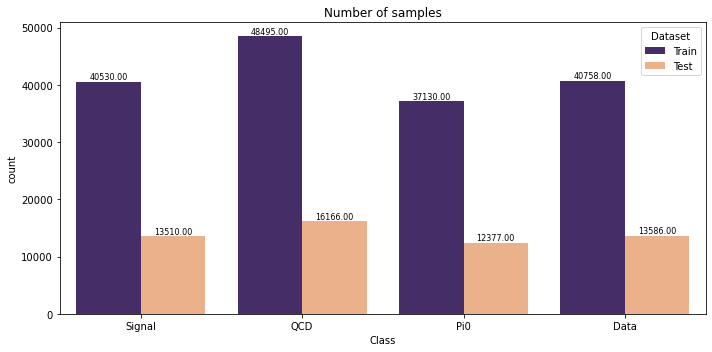

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
kplot=sns.countplot(x="Class", data=final_df, ax=axes,hue='Dataset',palette=['#432371',"#FAAE7B","black"])

for p in kplot.patches:
    kplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points',size=8)
axes.set_title("Number of samples")

 Making Train dataset spectator plots
0 0 Category
0 1 Category
0 2 Category
0 3 Category
1 0 Category
1 1 Category
1 2 Category
1 3 Category


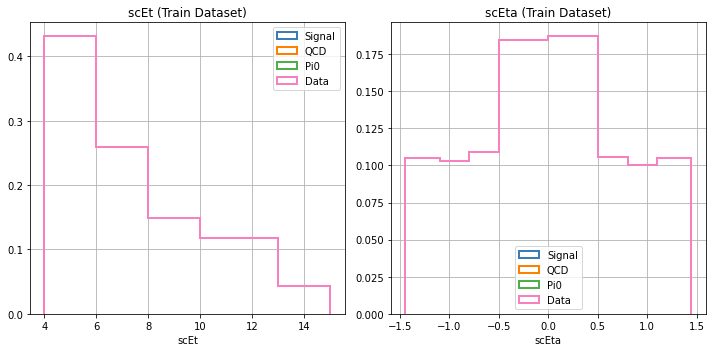

In [26]:
Variables=['scEt','scEta']
#VarBins=[[4,6,8,10,13,15], [-2.4,-2.0,-1.566,1.566,2.0,2.4]]
VarBins=[Conf.ptbins,Conf.etabins]
loca=['upper right','lower center']
MakeFeaturePlots(final_df,Variables,VarBins,Set="Train",OutputDirName=Conf.OutputDirName,label=Classes,log=False,locate=loca)

## Define MVA parameters as a dictionary 

In [27]:
import pickle
import multiprocessing
import seaborn as sns

In [28]:
MVA = {"MVAtype":"XGB_1", #Keyword to identify MVA method.
     "Color":"green", #Plot color for MVA
     "Label":"XGB small list", # label can be anything (this is how you will identify them on plot legends)
     "features":['scEtaWidth','scR9','scSigmaIetaIeta','scSigmaIetaIphi','scEMaxRatio','scSwissCross','scE2x5_MaxRatio','scE2ndRatio','scPFChIso1','scPFChIso3','scPFChIso5'],
     "feature_bins":[MyBins(0,0.1,0.001), MyBins(0,1,0.01), MyBins(0,0.1,0.001),MyBins(0,0.002,0.00001),MyBins(0,1,0.01),MyBins(0,1,0.01),MyBins(0,1,0.01),MyBins(0,1,0.01), 
                    MyBins(0,100,1),MyBins(0,100,1),MyBins(0,100,1)], #same length as features #Binning used only for plotting features (should be in the same order as features), 
     'Scaler':"StandardScaler", #Scaling for features before passing to the model training
     'UseGPU':False, #If you have a GPU card, you can turn on this option (CUDA 10.0, Compute Capability 3.5 required)
     "XGBGridSearch":{'colsample_bytree': [0.5,1.0], 'gamma': [0.5], 'max_depth': [5,3], 'min_child_weight': [5], 'subsample': [0.8]}
      }

os.system("mkdir -p " + Conf.OutputDirName+"/"+MVA["MVAtype"])

0

## Data preparation 

In [29]:
def PrepDataset(df_final,TrainIndices,TestIndices,features,cat,weight):
    X_train = df_final.loc[TrainIndices,features]
    Y_train = df_final.loc[TrainIndices,cat]
    Wt_train = df_final.loc[TrainIndices,weight]

    X_test = df_final.loc[TestIndices,features]
    Y_test = df_final.loc[TestIndices,cat]
    Wt_test = df_final.loc[TestIndices,weight]
    return np.asarray(X_train), np.asarray(Y_train), np.asarray(Wt_train), np.asarray(X_test), np.asarray(Y_test), np.asarray(Wt_test)

# prepare dataset

In [30]:
X_train, Y_train, Wt_train, X_test, Y_test, Wt_test = PrepDataset(final_df,TrainIndices,TestIndices,MVA["features"],cat='Category',weight="NewWt")
exec("from sklearn.preprocessing import "+MVA["Scaler"])
exec("sc = "+MVA["Scaler"]+"()")
#scale the training data input features so that it is between 0 and 1
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test)
pickle.dump(sc, open(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"_scaler.pkl",'wb'))

## XGBoost- training

Fitting 3 folds for each of 4 candidates, totalling 12 fits
 Expected neg log loss of XGB model = -62.2%
 XGB Best Parameters
 {'colsample_bytree': 1.0, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8}
Execution time is 451.88901114463806


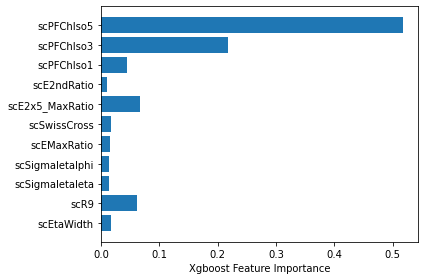

In [31]:
start = time.time()


    
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV
eval_s = [(X_train, Y_train),(X_test,Y_test)]

#if "UseGPU" in MVA and MVA["UseGPU"]:
 #   xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method= 'gpu_hist',random_state=42)
#else:
xgb_model = xgb.XGBClassifier(objective="multi:softmax",random_state=42,num_class=4)

cv = GridSearchCV(xgb_model, MVA["XGBGridSearch"],scoring='neg_log_loss',cv=3,verbose=1)
search=cv.fit(X_train, Y_train, sample_weight=Wt_train,verbose=0,eval_set=eval_s)
pickle.dump(cv, open(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"modelXGB.pkl", "wb"))
prGreen("Expected neg log loss of XGB model = "+str((np.round(np.average(search.best_score_),3))*100)+'%')
prGreen("XGB Best Parameters")
prGreen(str(search.best_params_))
fig, ax = plt.subplots()
ax.barh(MVA["features"],cv.best_estimator_.feature_importances_)
ax.set_xlabel("Xgboost Feature Importance")

#X_train, Y_train, Wt_train, X_test, Y_test, Wt_test, cv, search=runXGBTraining(final_df,TrainIndices,TestIndices,MVA,sc,cat='Category',weight="NewWt")

end = time.time()
print("Execution time is", end-start)

In [32]:
#from xgboost import plot_tree
#plot_tree(booster=search,trees=1)
#plt.show()

## Diagnostic error plot 

In [33]:
results = cv.best_estimator_.evals_result()


In [34]:
#print(results)

Text(0.5, 1.0, 'XGB small list XGBoost Error')

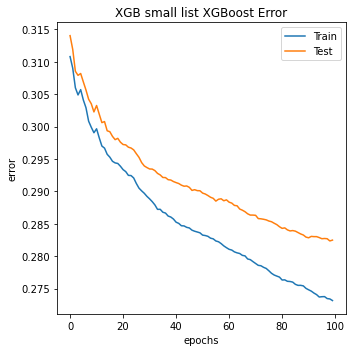

In [35]:
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(5,5))
        
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
ax.set_ylabel('error')
ax.set_xlabel('epochs')
ax.set_title(MVA["Label"]+' XGBoost Error')

In [36]:
from tensorflow.keras.utils import to_categorical
y_test_pred=cv.predict_proba(X_test)
y_train_pred=cv.predict_proba(X_train)

Y_train = to_categorical(Y_train, num_classes=4)
Y_test = to_categorical(Y_test, num_classes=4)

In [37]:
y_train_pred

array([[0.816399  , 0.07385094, 0.00931514, 0.10043497],
       [0.5572262 , 0.20407738, 0.00114995, 0.23754649],
       [0.8261694 , 0.05953487, 0.00451258, 0.10978323],
       ...,
       [0.50369996, 0.14289209, 0.0015225 , 0.35188547],
       [0.3664749 , 0.2859694 , 0.00165883, 0.34589687],
       [0.32533243, 0.17812294, 0.00115851, 0.49538618]], dtype=float32)

In [38]:
cv.predict_proba

<function sklearn.model_selection._search.BaseSearchCV.predict_proba(self, X)>

In [39]:
final_df.loc[TrainIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_train)[:,0]
final_df.loc[TestIndices,MVA["MVAtype"]+"_pred"]=cv.predict_proba(X_test)[:,0]

In [40]:
final_df

,scE,scEt,scEta,scPhi,scEtaWidth,scMinDrWithGsfElectornSC_,scFoundGsfMatch_,scR9,scSigmaIetaIeta,scSigmaIetaIphi,scEMaxRatio,scSwissCross,scE2x5_MaxRatio,scE2ndRatio,scPFPhoIso1,scPFPhoIso2,scPFPhoIso3,scPFPhoIso4,scPFPhoIso5,scPFChIso1,scPFChIso2,scPFChIso3,scPFChIso4,scPFChIso5,Class,Category,NewWt,xsecwt,Dataset,TrainDataset,XGB_1_pred
0,7.612641,4.364994,1.154637,2.458142,0.014297,1.000000e+09,0.0,0.886470,0.007114,0.000002,0.656240,0.476167,1.000000,0.148881,3.372590,3.372590,4.238997,5.962224,6.208840,2.616682,2.616682,5.633833,8.048589,12.063632,Signal,0,1.000000,1,Train,1.0,0.521893
1,10.268811,5.444023,-1.248644,-0.664056,0.036444,1.000000e+09,0.0,0.703200,0.015309,-0.000089,0.571211,0.445584,0.897011,0.265132,3.351559,3.611530,3.611530,4.889325,7.142009,0.000000,1.596442,2.422061,8.291380,10.248260,Signal,0,1.000000,1,Train,1.0,0.165069
2,7.321876,5.001083,0.929557,-0.933871,0.007651,2.245841e+00,0.0,0.688784,0.009387,0.000026,0.723485,0.736497,1.000000,0.108718,4.350082,4.660449,5.993894,8.206876,9.328171,1.887269,2.423234,6.402352,11.477100,16.647730,Signal,0,1.000000,1,Train,1.0,0.371511
3,8.477271,7.590605,0.478759,1.329975,0.008747,1.000000e+09,0.0,0.678506,0.008136,0.000028,0.513293,0.051796,1.000000,0.256654,1.674712,1.674712,2.029678,3.529204,4.279602,6.355587,10.682564,14.447303,16.944557,23.501209,Signal,0,1.000000,1,Train,1.0,0.064936
4,5.148602,4.997699,0.245128,-0.516368,0.004604,1.000000e+09,0.0,0.929679,0.007760,0.000008,0.872623,0.854030,1.000000,0.068986,4.839082,4.839082,4.839082,4.839082,5.123136,3.694202,5.177757,8.206908,10.729901,13.100916,Signal,0,1.000000,1,Test,0.0,0.401790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222547,9.333681,6.465915,-0.910093,-1.137695,0.007335,2.770633e+00,0.0,0.744882,0.009098,0.000000,0.720550,0.612170,1.000000,0.279450,6.100857,7.119668,9.888049,11.060945,11.263238,21.945841,28.801649,29.225948,29.710730,30.564978,Data,3,1.419737,1,Train,1.0,0.009269
222548,7.915595,7.481329,0.339098,2.203495,0.008375,2.607118e+00,0.0,0.998393,0.011032,0.000003,0.564805,0.599431,0.965407,0.174358,5.878809,9.360914,11.767120,11.767120,14.247921,27.538717,39.355255,42.648666,46.289780,60.435966,Data,3,1.646617,1,Train,1.0,0.006862
222549,4.442907,4.018610,-0.455578,1.413803,0.000973,1.000000e+09,0.0,0.929301,0.000000,0.000000,0.929648,0.924324,1.000000,0.070352,3.500710,3.500710,3.779369,3.779369,5.070140,1.127063,2.048072,4.197660,6.174308,10.791481,Data,3,0.729730,1,Train,1.0,0.731158
222550,8.873695,5.476982,-1.062960,2.430576,0.023189,1.000000e+09,0.0,0.613766,0.000000,0.000000,0.506421,0.025358,1.000000,0.493579,3.433844,6.029370,6.790549,7.202757,7.649904,8.400494,10.365823,13.361828,18.128450,26.615656,Data,3,0.609301,1,Train,1.0,0.068638


In [41]:
plotwt_train=np.asarray(final_df.loc[TrainIndices,'xsecwt'])
plotwt_test=np.asarray(final_df.loc[TestIndices,'xsecwt'])

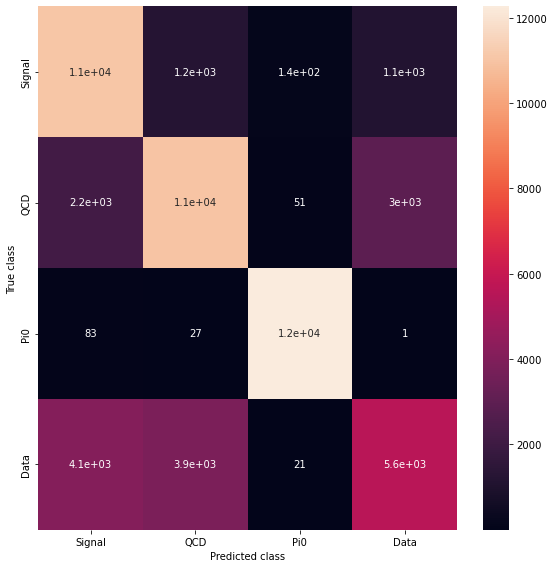

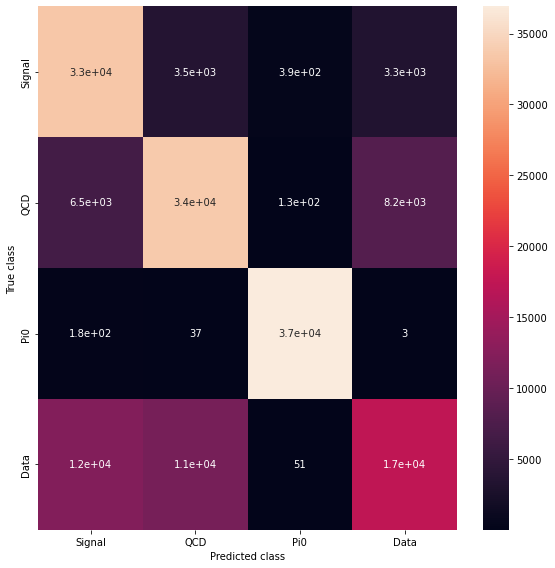

In [42]:
import pandas as pd

from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(1, 1, figsize=(len(Classes)*2, len(Classes)*2))
cm = confusion_matrix(Y_test.argmax(axis=1), y_test_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,index = Classes, columns = Classes)
sns.heatmap(cm_df, annot=True,ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), va='center')
axes.set_xticklabels(axes.get_yticklabels(), ha='center')
axes.set_ylabel("True class")
axes.set_xlabel("Predicted class")

fig, axes = plt.subplots(1, 1, figsize=(len(Classes)*2, len(Classes)*2))
cm = confusion_matrix(Y_train.argmax(axis=1), y_train_pred.argmax(axis=1))
cm_df = pd.DataFrame(cm,index = Classes,columns = Classes)
sns.heatmap(cm_df, annot=True,ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), va='center')
axes.set_xticklabels(axes.get_yticklabels(), ha='center')
axes.set_ylabel("True class")
axes.set_xlabel("Predicted class")
fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"CM_Training.png") 

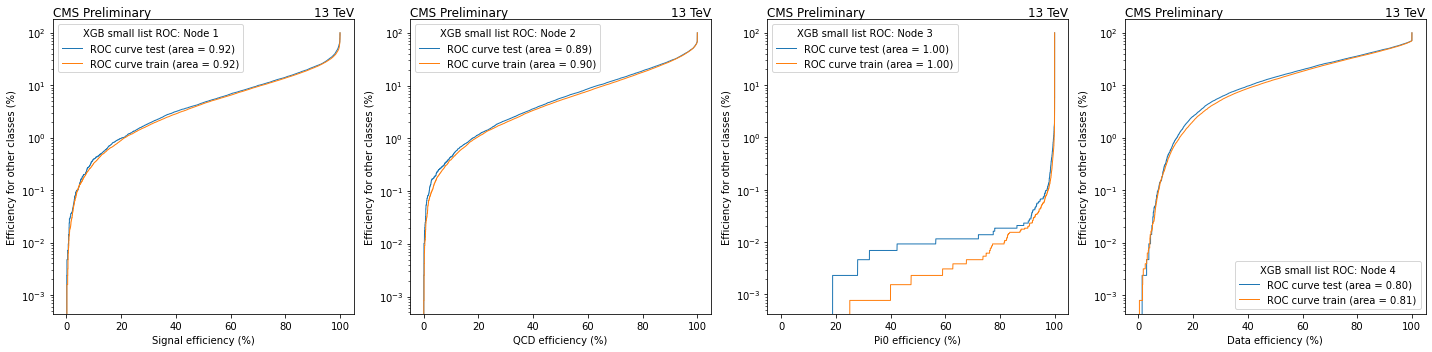

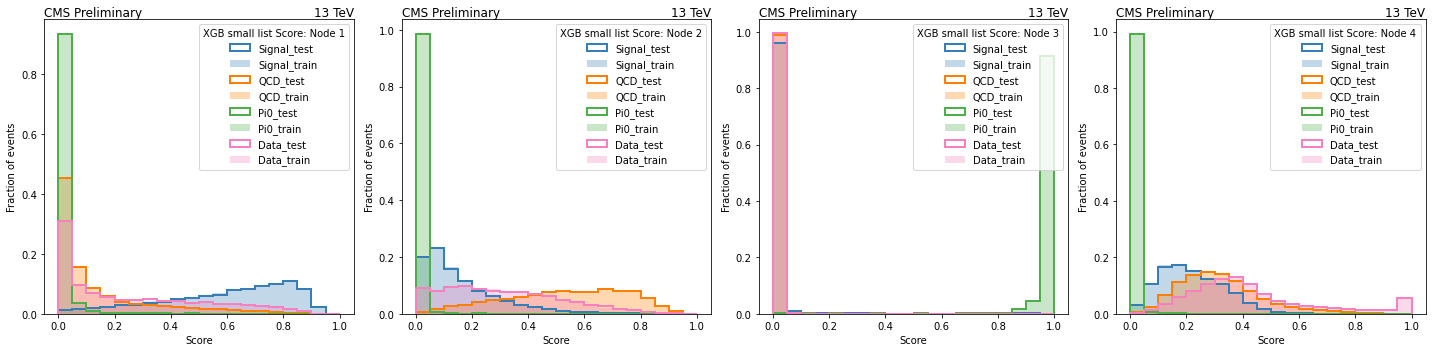

In [43]:
from sklearn.metrics import roc_curve, auc

n_classes=len(Classes)
fig, axes = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))
figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(n_classes*5, 5))    
for i in range(n_classes):
    axMVA=axesMVA[i]
    ax=axes[i]
    for k in range(n_classes):
        axMVA.hist(y_test_pred[:, i][Y_test[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_test',
                   weights=plotwt_test[Y_test[:, k]==1]/np.sum(plotwt_test[Y_test[:, k]==1]),
                   histtype='step',linewidth=2,color=ClassColors[k])
        axMVA.hist(y_train_pred[:, i][Y_train[:, k]==1],bins=np.linspace(0, 1, 21),label=Classes[k]+'_train',
                   weights=plotwt_train[Y_train[:, k]==1]/np.sum(plotwt_train[Y_train[:, k]==1]),
                   histtype='stepfilled',alpha=0.3,linewidth=2,color=ClassColors[k])
        
    axMVA.set_xlabel('Score',fontsize=10)
        
    axMVA.set_ylabel('Fraction of events',fontsize=10)
    axMVA.legend(title=MVA["Label"]+' Score: Node '+str(i+1), loc="best",fontsize=10)
    axMVA.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=axMVA.transAxes, fontsize = 12)#, fontweight = 'bold')
        
    axMVA.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = axMVA.transAxes, fontsize = 12)
    #axMVA.set_yscale('log')
            
    fpr, tpr, th = roc_curve(Y_test[:, i], y_test_pred[:, i],sample_weight=plotwt_test)
    fpr_tr, tpr_tr, th_tr = roc_curve(Y_train[:, i], y_train_pred[:, i],sample_weight=plotwt_train)
    mask = tpr > 0.0
    fpr, tpr = fpr[mask], tpr[mask]

    mask = tpr_tr > 0.0
    fpr_tr, tpr_tr = fpr_tr[mask], tpr_tr[mask]

    roc_auc = auc(fpr, tpr)
    roc_auc_tr = auc(fpr_tr, tpr_tr)
            
    ax.plot(tpr*100, fpr*100, label='ROC curve test (area = %0.2f)' % roc_auc,linewidth=1)
    ax.plot(tpr_tr*100, fpr_tr*100, label='ROC curve train (area = %0.2f)' % roc_auc_tr,linewidth=1)
    ax.text(0, 1, "CMS Preliminary", horizontalalignment = 'left', verticalalignment = 'bottom', transform=ax.transAxes, fontsize = 12)#, fontweight = 'bold')
    ax.text(1, 1, "13 TeV", horizontalalignment = 'right', verticalalignment = 'bottom', transform = ax.transAxes, fontsize = 12)
    ax.set_yscale("log")
    ax.set_xlabel(Classes[i]+' efficiency (%)',fontsize=10)
    ax.set_ylabel('Efficiency for other classes (%)',fontsize=10)
    ax.legend(title=MVA["Label"]+' ROC: Node '+str(i+1),loc="best",fontsize=10)

fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"ROC.pdf")
fig.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"ROC.png")
figMVA.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"MVA.pdf")
figMVA.savefig(Conf.OutputDirName+"/"+MVA["MVAtype"]+"/"+MVA["MVAtype"]+"_"+"MVA.png")

## Advanced exercise 

In [44]:
import math
from uncertainties import ufloat
from uncertainties.umath import *

In [45]:
def eff(group_df,var,cat,catvalue):
    signalpass=len(group_df.query('('+var+' == 1) & ('+cat+' == '+str(catvalue)+')'))
    signalpass=ufloat(signalpass,math.sqrt(signalpass))
    signaltotal=len(group_df.query('('+cat+' == '+str(catvalue)+')'))
    signaltoal=ufloat(signaltotal,math.sqrt(signaltotal))
    if signaltotal>0:
        signaleff=(100*signalpass)/(signaltotal)
        return [signaleff.n, signaleff.s]
    else:
        print("Some bins have zero signal: assigning zero eff")
        return [0, 0]

def EffTrend(cat='',var='',groupbyvar='',ptbins=[],label='',title='',plotname='',df=pd.DataFrame(),plot_dir='',Classes=[''],Colors=['']):
    figMVAComp, axesComp = plt.subplots(1,1, figsize=(4, 4))
    ax=axesComp
    fulllist=[[] for i in range(len(Classes))]
    fullliste=[[[] for i in range(2)] for i in range(len(Classes))]
    #ptbinsmy=ptbins[:-1]
    ptbinsmy=[(ptbins[m+1]+ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        ptbinsmy[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*1.2
    #ptbinsmy.append(ptbins[len(ptbins)-1]*1.2)
    xefulllist=[(ptbins[m+1]-ptbins[m])/2 for m in range(len(ptbins)-1)]
    if groupbyvar=='ele_pt_bin':
        xefulllist[len(ptbinsmy)-1]=ptbins[len(ptbins)-2]*0.2
    for i,group_df in df.groupby(groupbyvar):
        for k in range(len(Classes)):
            val=eff(group_df,var,cat,k)[0]
            vale=eff(group_df,var,cat,k)[1]
            fulllist[k].append(val)
            fullliste[k][0].append(vale)
            if val+vale<100:
                fullliste[k][1].append(vale)
            else:
                fullliste[k][1].append(100-val)
                
        
    for m in range(len(Classes)):
        if len(Classes)>2:
            if m==0 or m==1:
                marker='S'
            else:
                marker='B'
        if len(Classes)<3:
            if m==1:
                marker='S'
            else:
                marker='B'
        ax.errorbar(ptbinsmy,fulllist[m],xerr=xefulllist,yerr=fullliste[m],markersize=6,markeredgecolor='black',label=Classes[m],color=Colors[m],fmt = '.')
    ax.set_ylim(0,130)
    if groupbyvar=='ele_pt_bin':
        #ax.set_yscale('log')
        ax.set_xlim(ptbins[0],ptbins[len(ptbins)-2]*1.4)
    #if groupbyvar=='ele_eta_bin':
        #ax.set_xlim(ptbins[0]*1.2,ptbins[len(ptbins)-1])
    ax.set_xlabel(label)
    ax.set_ylabel("Efficiency (%)")
    ax.set_title(title)
    ax.grid(True)
    #ax.legend(loc='best',ncol=2,bbox_to_anchor=(0., 1.1, 1., 0.2),fontsize=8)
    ax.legend(loc='best',ncol=2,fontsize=10)
    figMVAComp.savefig(plot_dir+plotname+".pdf")
    figMVAComp.savefig(plot_dir+plotname+".png")

## Efficiency studies at 80% and 90% working points

In [46]:
SigEffWPsi=["80%", "90%"]
MVAs=[MVA]
#ptbins = [4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,12,15]
#etabins = [-2.4,-2.2,-2.0,-1.8,-1.566,1.566,1.8,2.0,2.2,2.4]
#etabins = [-1.4442,-1.1,-0.8,-0.5,0,0.5,0.8,1.1,1.4442]
ptbins = Conf.ptbins
etabins = Conf.etabins
ptwtvar='scEt'
etawtvar='scEta'

In [47]:
cat='Category'

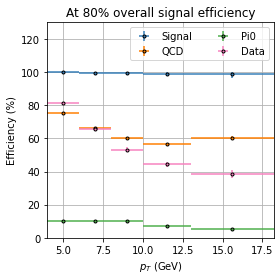

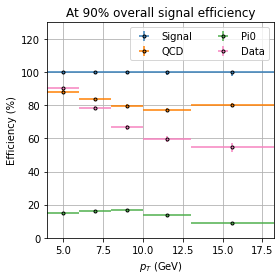

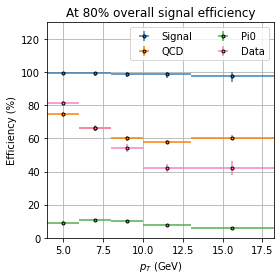

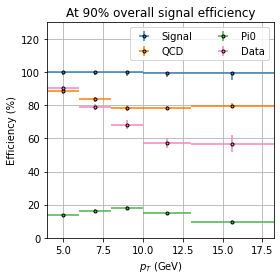

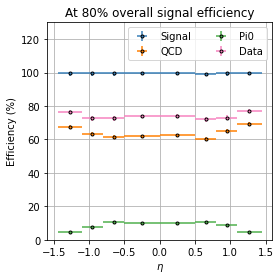

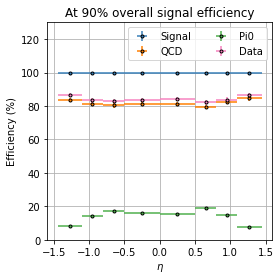

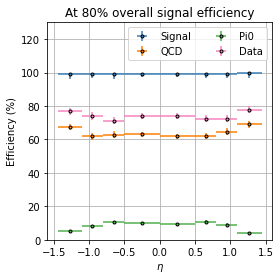

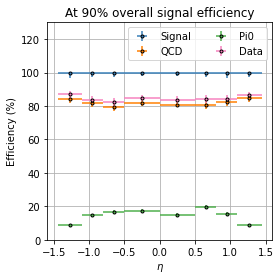

In [48]:
if len(SigEffWPsi)>0:
    PredMVAs=[]
    for MVA in MVAs:
        PredMVAs.append(MVA["MVAtype"]+'_pred')
    SigEffWPs=SigEffWPsi[:]
    for i,SigEffWPi in enumerate(SigEffWPs):
        SigEffWPs[i]=1-(int(SigEffWPi.replace('%', ''))/100)
    

    for MVA in MVAs:

        final_df["ele_pt_bin"] = pd.cut(final_df[ptwtvar], bins=ptbins, labels=list(range(len(ptbins)-1)))
        final_df["ele_eta_bin"] = pd.cut(final_df[etawtvar], bins=etabins, labels=list(range(len(etabins)-1)))

        EB_train=final_df.loc[TrainIndices]
        EB_test=final_df.loc[TestIndices]
        
        if len(Classes) > 2:
            
            mydftrain=EB_train.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==1 | "+cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
            #figMVA, axesMVA = plt.subplots(1, n_classes, figsize=(5, 5))
            #plot_mva(EB_train, MVA["MVAtype"]+"_pred", 100, logscale=False, ax=axMVA, title="Combined Score", ls='dashed', alpha=0.5, sample='Train',cat="Class",Wt="Wt",Classes=Classes,Colors=ClassColors)
            
        if len(Classes) < 3:
            
            mydftrain=EB_train.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            mydftest=EB_test.query(cat+"==0")[[MVA["MVAtype"]+"_pred"]].quantile(SigEffWPs)
            
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] > mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_train.loc[EB_train[MVA["MVAtype"]+"_pred"] < mydftrain.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[0,0], MVA["MVAtype"]+"_predpass"] = 0

        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] > mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 1
        EB_test.loc[EB_test[MVA["MVAtype"]+"_pred"] < mydftest.iat[1,0], MVA["MVAtype"]+"_predpass1"] = 0

        variables=['ele_pt_bin','ele_eta_bin']
        bins=[ptbins,etabins]
        xaxislabels=['$p_T$ (GeV)','$\eta$']
        #Wps=OverlayWP

        for variable,xaxislabel,binn in zip(variables,xaxislabels,bins):
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[0])+"_"+variable,df=EB_train,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[1])+"_"+variable,df=EB_train,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)
            #for Wp in Wps:
             #   EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_train,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Train_",Classes=Classes,Colors=ClassColors)


            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[0]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[0])+"_"+variable,df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)
            EffTrend(cat=cat,var=MVA["MVAtype"]+"_predpass1",groupbyvar=variable,ptbins=binn,label=xaxislabel,title=f"At {SigEffWPsi[1]} overall signal efficiency",plotname="New_MultiClass_ID_Val_"+str(SigEffWPs[1])+"_"+variable,df=EB_test,plot_dir=Conf.OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)
            #for Wp in Wps:
             #   EffTrend(cat=cat,var=Wp,groupbyvar=variable,ptbins=binn, label=xaxislabel,title='CMSSW_ID_'+Wp,plotname="CMSSW_ID_"+Wp+"_"+variable,df=EB_test,plot_dir=OutputDirName+"/"+MVA["MVAtype"]+"/Test_",Classes=Classes,Colors=ClassColors)